# Testing rf and LSTM on dataset from Kostas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from LSTM import long_short_term_memory as LSTM
from rf import rf

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']
    
    X, mode = df[features], df[['Mode', 'campaign']]
    return X, mode


'''
    Returns a sequence indicating if a handover has happened when predicting 1 timestep ahead
'''
def check_handover(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y.iloc[i] == y.iloc[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y.iloc[i] == 0 and y.iloc[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y.iloc[i] == 1 and y.iloc[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

def check_handover_array(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y[i] == y[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y[i] == 0 and y[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y[i] == 1 and y[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

In [4]:
train_total_df, train_total_mode = read_dataset('datasets/train_TIM_LSTM.csv')
print(train_total_df['campaign'].value_counts())

test_total_df, test_total_mode = read_dataset('datasets/test_TIM_LSTM.csv')
print(test_total_df['campaign'].value_counts())

Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia                  1714
Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET                                 1363
Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode       1108
Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel                           849
Interactiviy_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode     840
Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode      834
Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini                                  756
Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode            744
Ping_UNIDATA_4G5G_TIM_Driving_Via_Normanni_to_Sabino                           684
Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel                 609
Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode             581
Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia                             531
Ping

## LSTM-prediction of signal strength indicators

In [5]:
tf.random.set_seed(4567)

train, mode_train = read_dataset('datasets/train_TIM_LSTM.csv')
test, mode_test = read_dataset('datasets/test_TIM_LSTM.csv')

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

results = {}
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [ # ['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                    #  ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                    #  ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [6]:
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            print(used_features)
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            results[used_features] = LSTM(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=5, n_steps_out=1, campaigns=campaigns, test_campaigns=test_campaigns)

RSRP, SINR -> RSRP
RSRP, RSRQ -> RSRP
RSRP, SINR, RSRQ -> RSRP
All -> RSRP
RSRP, SINR -> SINR
SINR, RSRQ -> SINR
RSRP, SINR, RSRQ -> SINR
All -> SINR
RSRP, RSRQ -> RSRQ
SINR, RSRQ -> RSRQ
RSRP, SINR, RSRQ -> RSRQ
All -> RSRQ
SSS_RSRP, SSS_SINR -> SSS_RSRP
SSS_RSRP, SSS_RSRQ -> SSS_RSRP
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP
All -> SSS_RSRP
SSS_RSRP, SSS_SINR -> SSS_SINR
SSS_SINR, SSS_RSRQ -> SSS_SINR
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR
All -> SSS_SINR
SSS_RSRP, SSS_RSRQ -> SSS_RSRQ
SSS_SINR, SSS_RSRQ -> SSS_RSRQ
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ
All -> SSS_RSRQ


In [7]:
df_results = pd.DataFrame.from_dict(results, orient='index')

df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR -> RSRP",0.00140,0.00092,1.80,1.40
1,"RSRP, RSRQ -> RSRP",0.00139,0.00094,1.86,1.51
2,"RSRP, SINR, RSRQ -> RSRP",0.00139,0.00091,1.79,1.41
3,All -> RSRP,0.00142,0.00086,1.72,1.25
4,"RSRP, SINR -> SINR",0.00335,0.00218,1.77,1.00
5,"SINR, RSRQ -> SINR",0.00340,0.00282,2.57,1.93
6,"RSRP, SINR, RSRQ -> SINR",0.00339,0.00226,1.92,1.18
7,All -> SINR,0.00338,0.00232,2.01,1.32
8,"RSRP, RSRQ -> RSRQ",0.00184,0.00148,1.02,0.77
9,"SINR, RSRQ -> RSRQ",0.00183,0.00137,0.98,0.70


### Plots for signal strength indicators

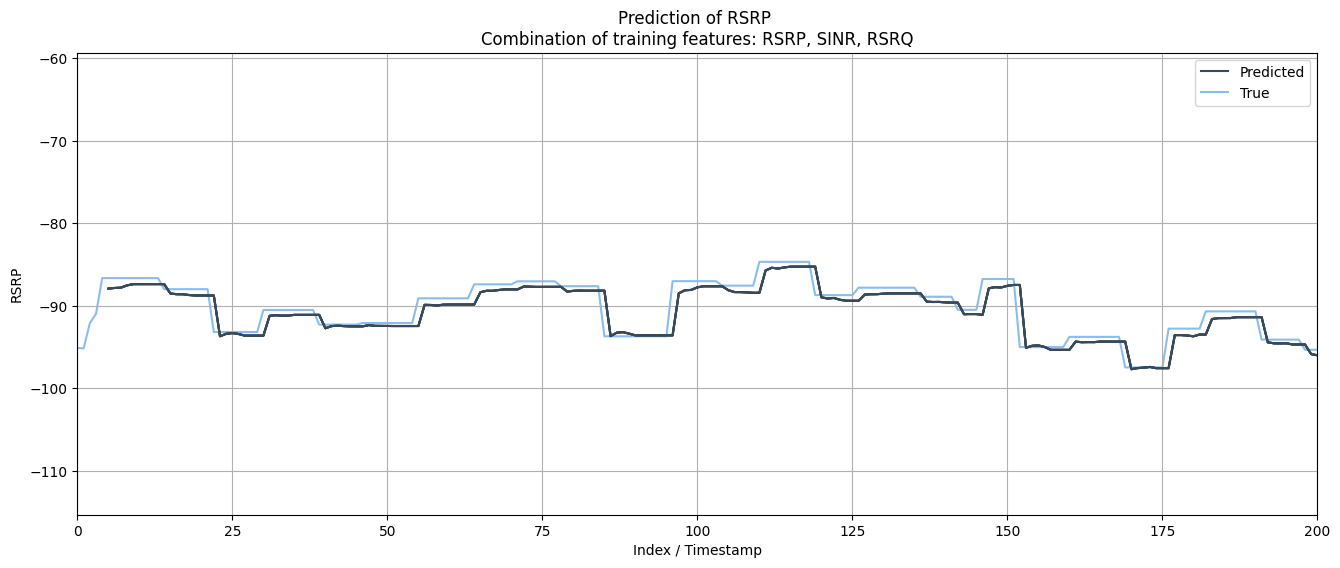

In [8]:
selected_rsrp_comb = 'RSRP, SINR, RSRQ -> RSRP'
rsrp_comb = results[selected_rsrp_comb]
rsrp_pred = rsrp_comb['y_pred']
rsrp_true = rsrp_comb['y_true']
rsrp_train_pred = rsrp_comb['train_pred']
rsrp_train_true = rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of RSRP \nCombination of training features: RSRP, SINR, RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

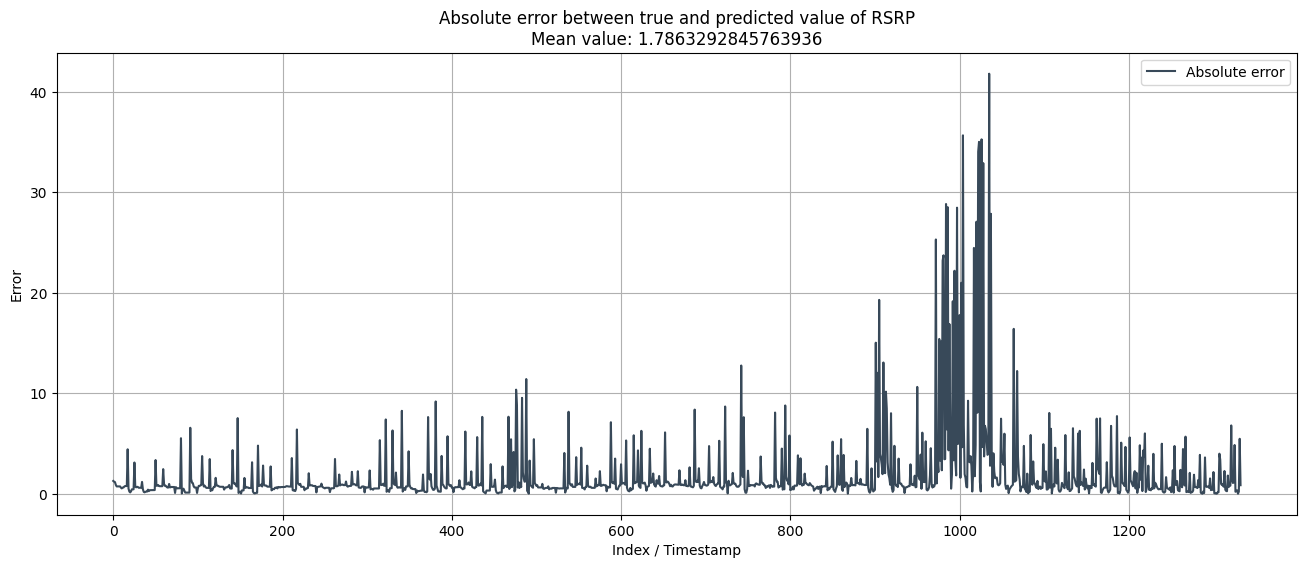

In [9]:
rsrp_list_mad = rsrp_comb['list_mae']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
mad = plt.plot(rsrp_list_mad, label='Absolute error', color=rsrp_colors[0], zorder=2)
plt.xlabel('Index / Timestamp')
plt.ylabel('Error')
# plt.xlim((0, 200))
plt.title(f'Absolute error between true and predicted value of RSRP\nMean value: {np.mean(rsrp_list_mad)}')
plt.legend()
plt.show()

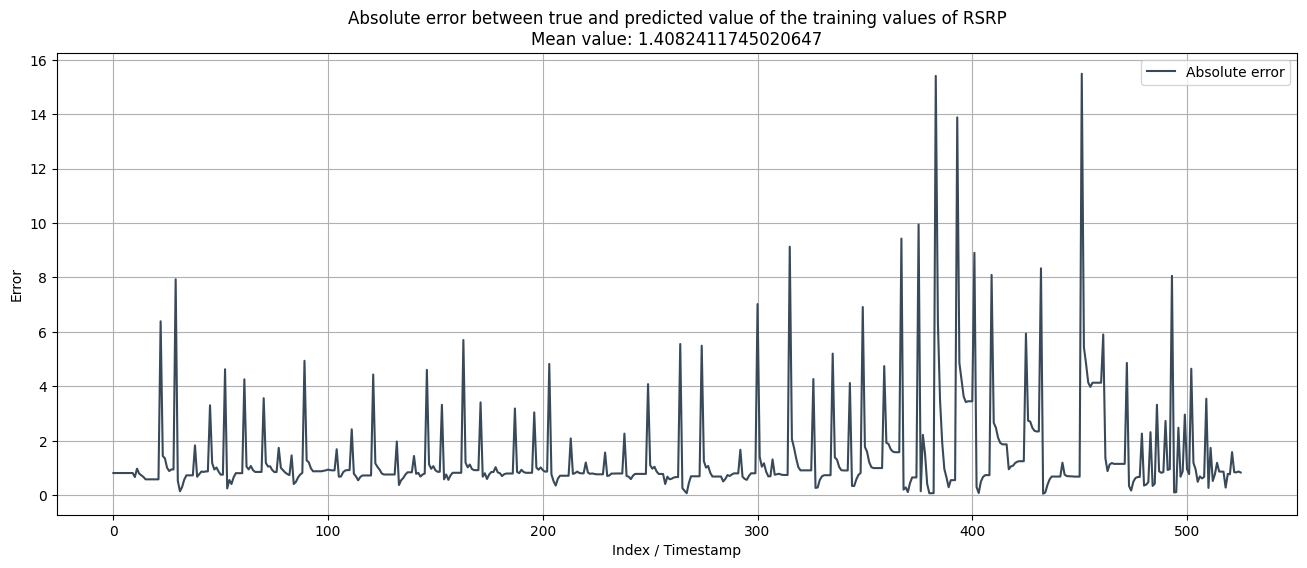

In [10]:
rsrp_train_list_mad = rsrp_comb['train_list_mae']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
mad = plt.plot(rsrp_train_list_mad, label='Absolute error', color=rsrp_colors[0], zorder=2)
plt.xlabel('Index / Timestamp')
plt.ylabel('Error')
# plt.xlim((0, 200))
plt.title(f'Absolute error between true and predicted value of the training values of RSRP\nMean value: {np.mean(rsrp_train_list_mad)}')
plt.legend()
plt.show()

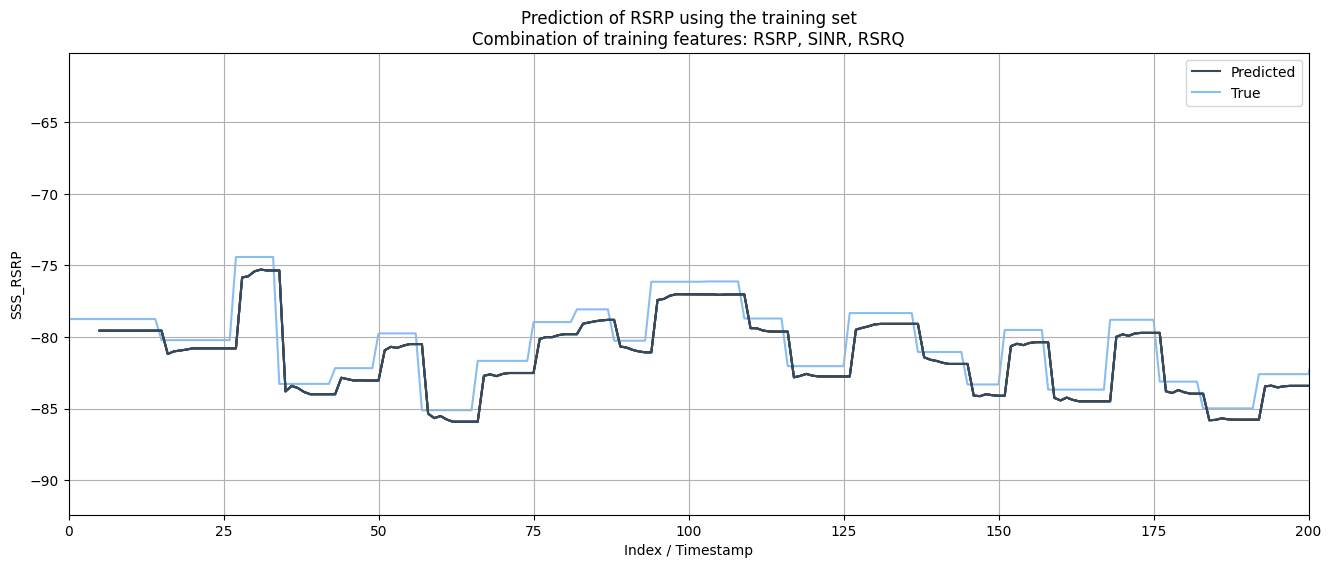

In [11]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of RSRP using the training set\nCombination of training features: RSRP, SINR, RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

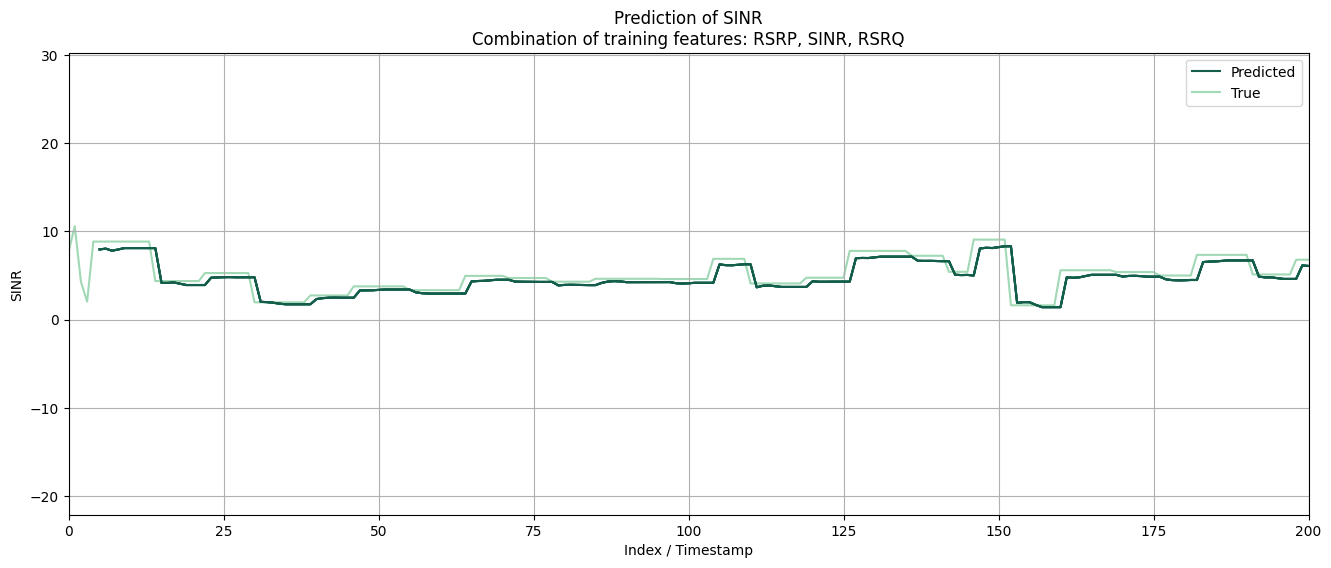

In [12]:
selected_sinr_comb = 'RSRP, SINR, RSRQ -> SINR'
sinr_comb = results[selected_sinr_comb]
sinr_pred = sinr_comb['y_pred']
sinr_true = sinr_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sinr_pred, label='Predicted', color=sinr_colors[0], zorder=2)
true = plt.plot(sinr_true, label='True', color=sinr_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SINR')
plt.title(f'Prediction of SINR\nCombination of training features: RSRP, SINR, RSRQ')
plt.xlim((0, 200))
plt.legend(handles=[pred[0], true[0]])
plt.show()

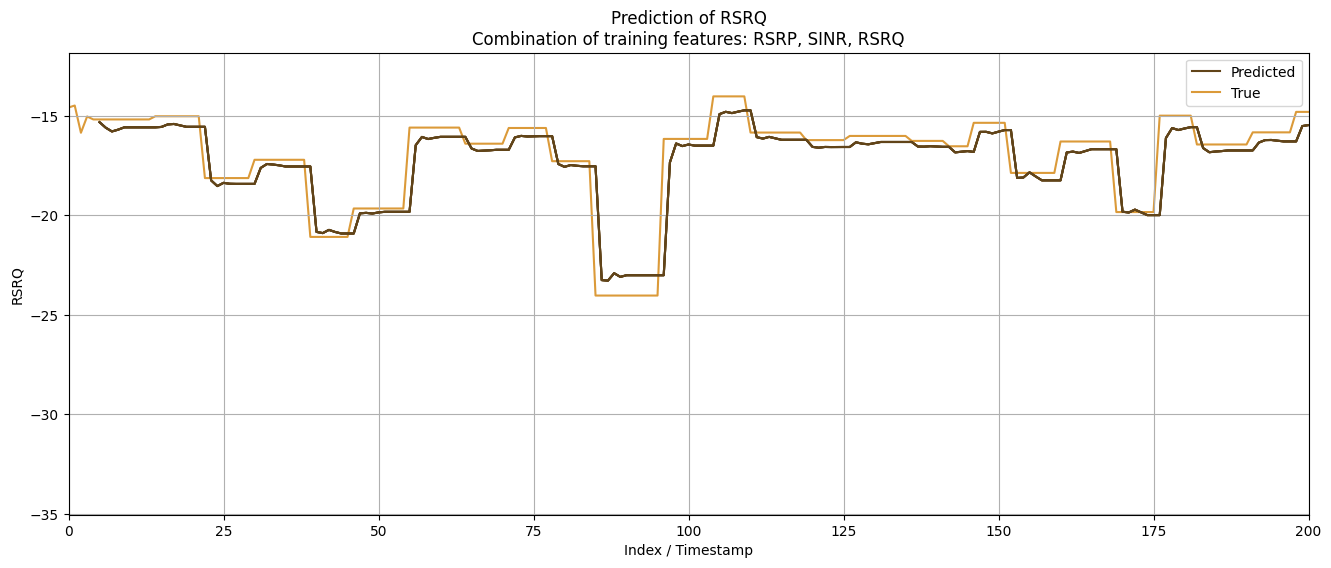

In [13]:
selected_rsrq_comb = 'RSRP, SINR, RSRQ -> RSRQ'
rsrq_comb = results[selected_rsrq_comb]
rsrq_pred = rsrq_comb['y_pred']
rsrq_true = rsrq_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(rsrq_pred, label='Predicted', color=rsrq_colors[0], zorder=2)
true = plt.plot(rsrq_true, label='True', color=rsrq_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRQ')
plt.xlim((0, 200))
plt.title(f'Prediction of RSRQ\nCombination of training features: RSRP, SINR, RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

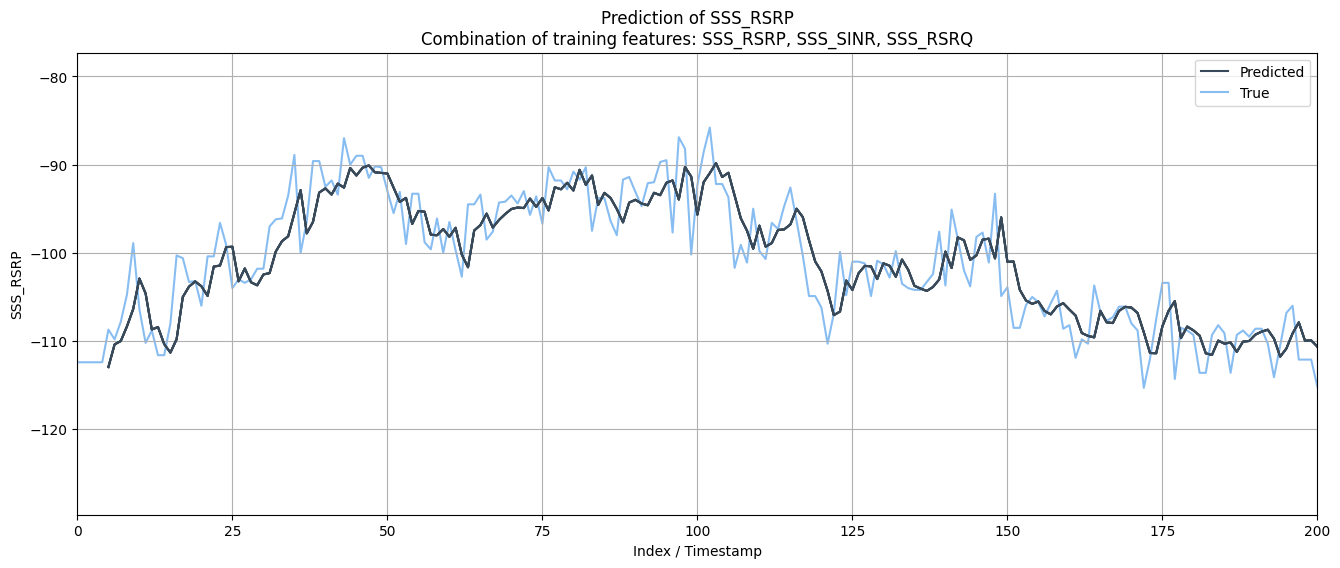

In [14]:
selected_sss_rsrp_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP'
sss_rsrp_comb = results[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred']
sss_rsrp_true = sss_rsrp_comb['y_true']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred']
sss_rsrp_train_true = sss_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_RSRP\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

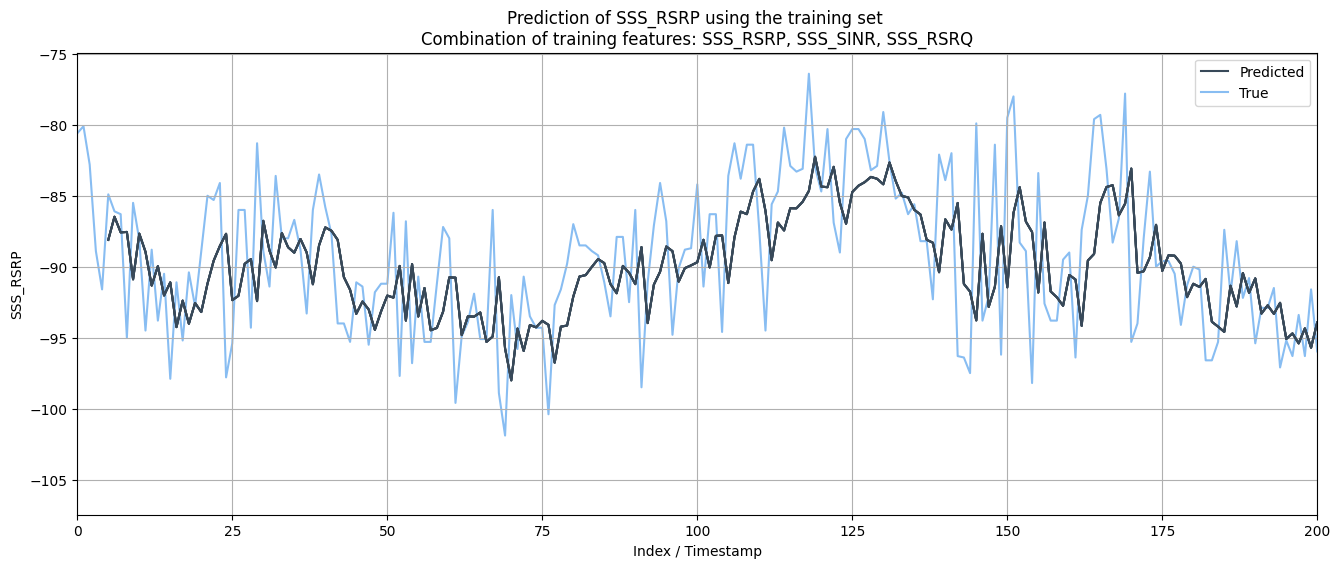

In [15]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of SSS_RSRP using the training set \nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

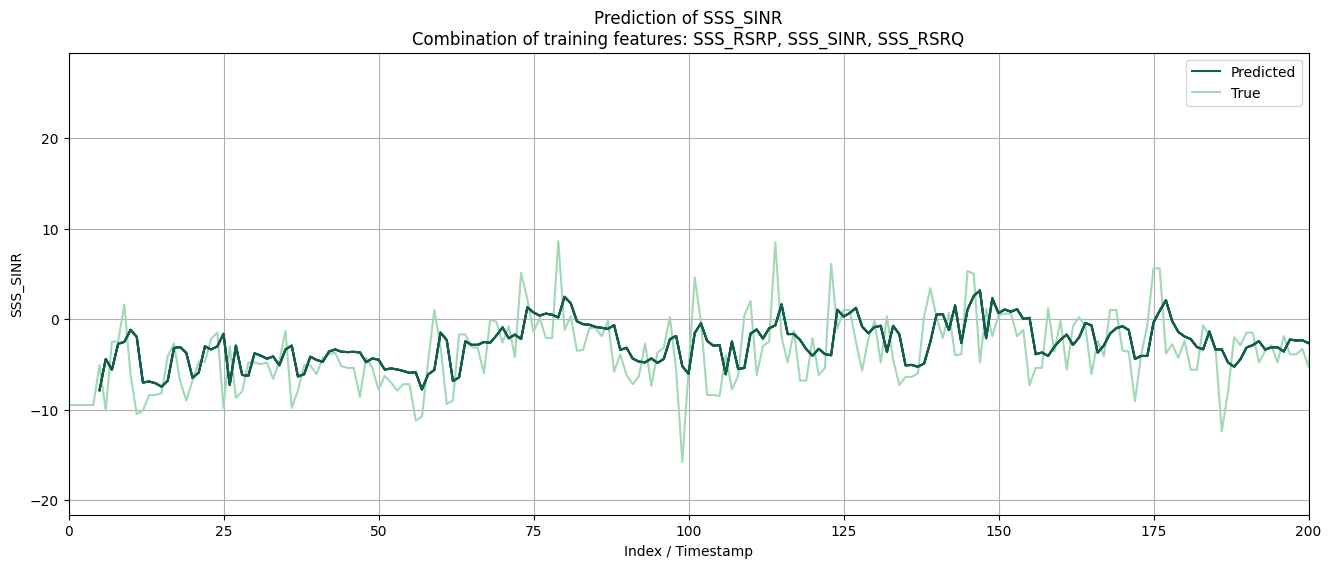

In [16]:
selected_sss_sinr_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR'
sss_sinr_comb = results[selected_sss_sinr_comb]
sss_sinr_pred = sss_sinr_comb['y_pred']
sss_sinr_true = sss_sinr_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_sinr_pred, label='Predicted', color=sinr_colors[0], zorder=3)
true = plt.plot(sss_sinr_true, label='True', color=sinr_colors[2], zorder=2)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_SINR')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_SINR\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

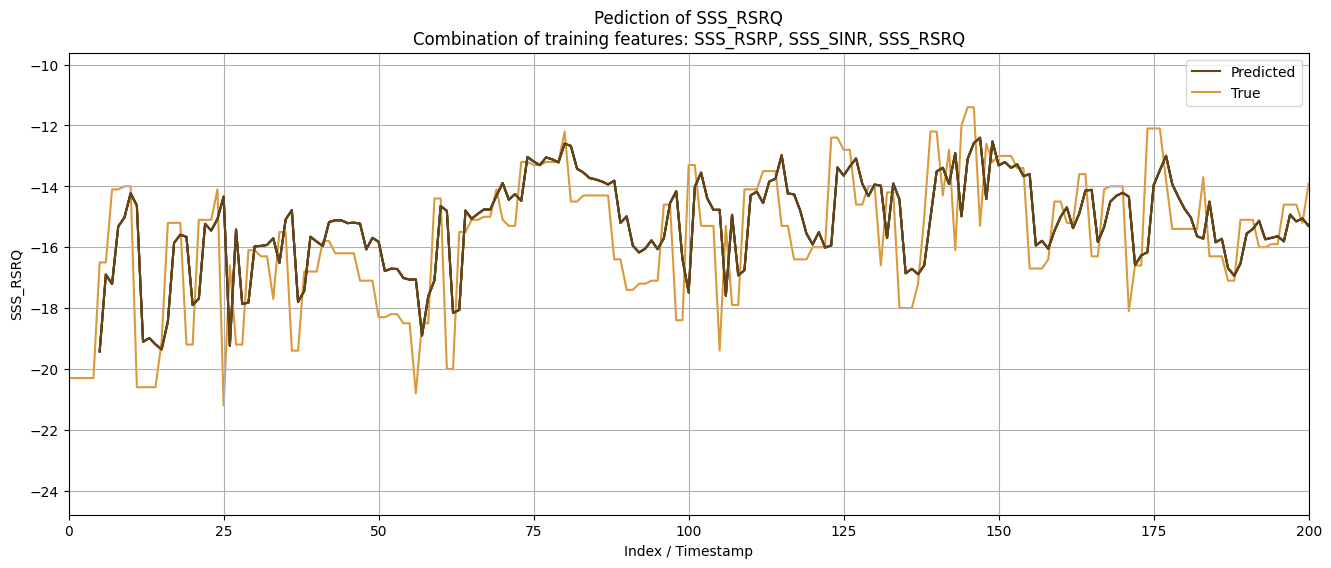

In [17]:
selected_sss_rsrq_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ'
sss_rsrq_comb = results[selected_sss_rsrq_comb]
sss_rsrq_pred = sss_rsrq_comb['y_pred']
sss_rsrq_true = sss_rsrq_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrq_pred, label='Predicted', color=rsrq_colors[0], zorder=2)
true = plt.plot(sss_rsrq_true, label='True', color=rsrq_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRQ')
plt.xlim((0, 200))
plt.title(f'Pediction of SSS_RSRQ\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

In [18]:
preds = pd.DataFrame({'RSRP' : [x[0] for x in rsrp_pred],
                      'SINR' : [x[0] for x in sinr_pred],
                      'RSRQ' : [x[0] for x in rsrq_pred],
                      'SSS_RSRP': [x[0] for x in sss_rsrp_pred],
                      'SSS_SINR': [x[0] for x in sss_sinr_pred],
                      'SSS_RSRQ': [x[0] for x in sss_rsrq_pred]},
                      columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'])

## Classification of mode using Random Forest

In [19]:
rf_results = {}

for features in feature_selection:
    used_features = ', '.join(features)
    feats = features.copy()
    feats.append('campaign')
    rf_results[used_features] = rf(X_train=train[feats], X_test=test[feats], mode_train=mode_train, mode_test=mode_test, n_estimators=200, campaigns=campaigns, test_campaigns=test_campaigns, features=features)
    feats.remove('campaign')

rf_results_df = pd.DataFrame.from_dict(rf_results, orient='index')
rf_results_df.reset_index(inplace=True)
rf_results_df.rename(columns={'index': 'Combination'}, inplace=True)
rf_results_df = rf_results_df.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
rf_results_df

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"RSRP, SINR",0.521,0.508,0.278,0.988,0.981,0.989
1,"RSRP, RSRQ",0.527,0.524,0.244,0.988,0.979,0.990
2,"SINR, RSRQ",0.521,0.510,0.252,0.989,0.981,0.989
3,"RSRP, SINR, RSRQ",0.531,0.538,0.213,0.989,0.981,0.989
4,"SSS_RSRP, SSS_SINR",0.585,0.588,0.471,0.979,0.977,0.966
5,"SSS_RSRP, SSS_RSRQ",0.565,0.561,0.460,0.899,0.875,0.857
6,"SSS_SINR, SSS_RSRQ",0.590,0.590,0.497,0.813,0.755,0.755
7,"SSS_RSRP, SSS_SINR, SSS_RSRQ",0.637,0.651,0.538,0.996,0.997,0.993
8,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ",0.630,0.659,0.487,1.000,1.000,1.000


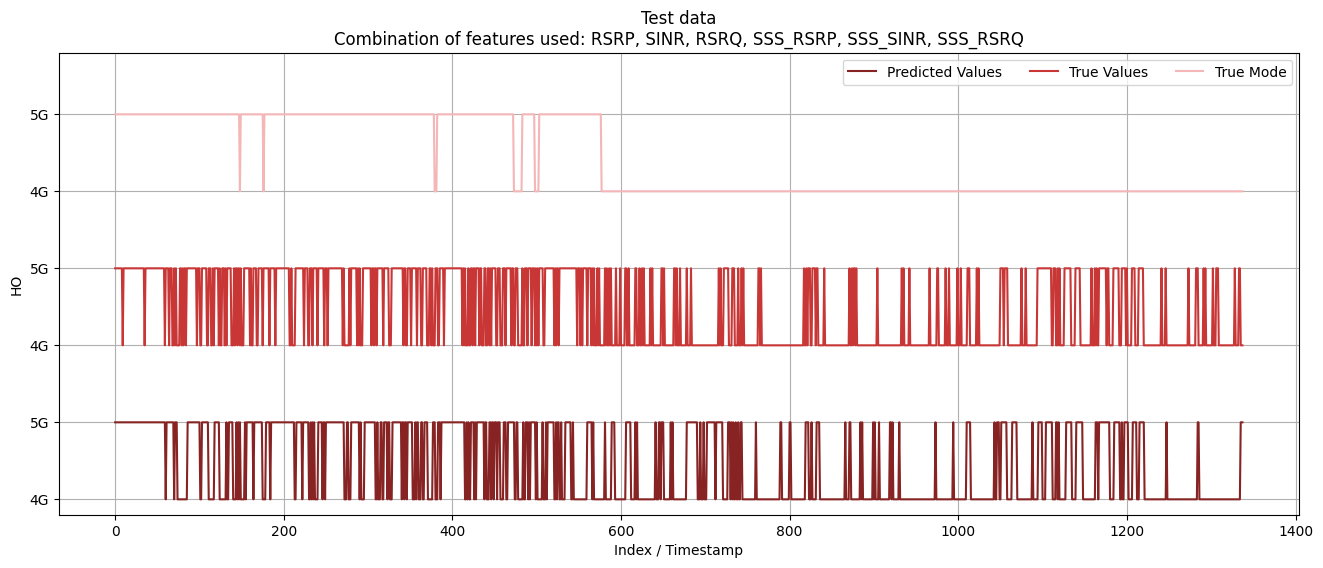

In [20]:
selected_rf_comb = 'RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ'
list_selected_comb = selected_rf_comb.split(', ')
rf_comb = rf_results[selected_rf_comb]
rf_model = rf_comb['model']
rf_pred_true = rf_comb['y_pred']
rf_true = rf_comb['y_true']
rf_pred = rf_model.predict(preds[list_selected_comb])

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[0], label='Predicted Values', zorder=4)
plt.plot(rf_pred_true + 2, color=mode_colors[1], label='True Values', zorder=2)
plt.plot(rf_true['Mode'] + 4, color=mode_colors[3], label='True Mode', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 5.8))
# plt.xlim((-100, 5750))
# plt.xlim((5600, 5750))
plt.yticks([0, 1, 2, 3, 4, 5], ['4G', '5G', '4G', '5G', '4G', '5G'])
plt.title(f'Test data\nCombination of features used: {selected_rf_comb}')
plt.legend(ncols=3, loc='best')
plt.show()

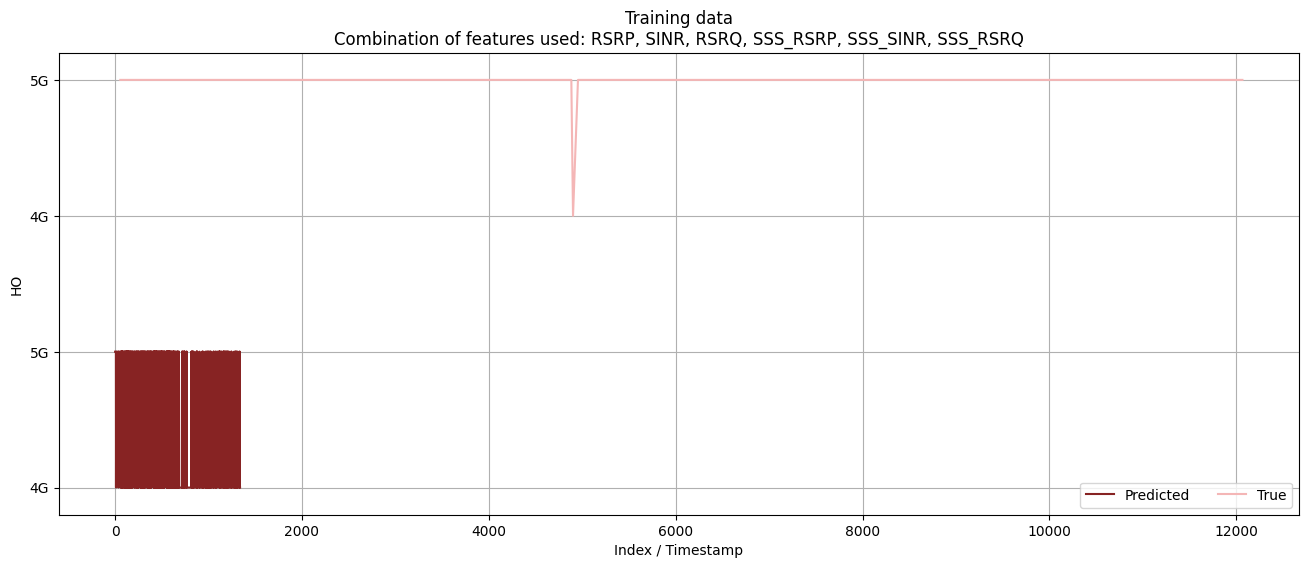

In [21]:
rf_pred_true_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_true, color=mode_colors[0], label='Predicted', zorder=4)
plt.plot(rf_true_train['Mode'] + 2, color=mode_colors[3], label='True', zorder=2)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.2))
# plt.xlim((-100, 5750))
# plt.xlim((5600, 5750))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Training data\nCombination of features used: {selected_rf_comb}')
plt.legend(ncols=3, loc='best')
plt.show()